# Filter fragments for synthesizability

## Aim of this notebook

This notebook is filtering the fragments for synthesizabity.
The first filter checks the availablility of similar buyable building blocks in [Enamine REAL Space](https://enamine.net/compound-collections/real-compounds/real-space-navigator), to ensure that the resulting molecules can easily be generated .
The second filter calculates the SYnthetic Bayesian Accessibility ([SYBA](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2)), which calculates an estimate wether a fragment is more likely to be easy to synthesize or hard to synthesize.

## Table of contents
* 1. Load fragment library
* 2. Apply pre-filters
* 3. Filter for buyable building blocks
   * 3.1. Data preparation
   * 3.2. Filter fragments for buyable building blocks
* 4. Filter for SYnthetic Bayesian Accessibility (SYBA)
* 5. Analyse accepted/rejected fragments

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from pathlib import Path

import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Lipinski, PandasTools

from kinfraglib import utils
from kinfraglib import filters

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

## Globals

In [4]:
# Path to data
HERE = Path(_dh[-1])
PATH_DATA = HERE / '../../data'

## 1. Load fragment library

In [5]:
fragment_library = utils.read_fragment_library(PATH_DATA / 'fragment_library')

In [6]:
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [7]:
pd.concat(fragment_library).reset_index(drop=True).shape

(7486, 15)

## 2. Apply pre-filters
Pre-filters are 
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [8]:
fragment_library_pre_filtered = filters.prefilters.pre_filters(
    fragment_library)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]"
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]"
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE]
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]"
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]"

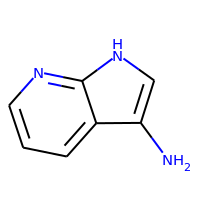
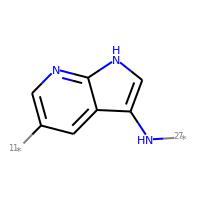
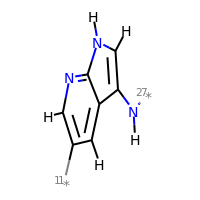
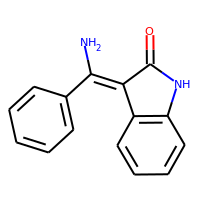
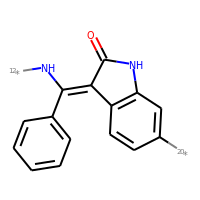
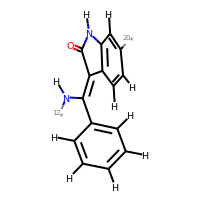
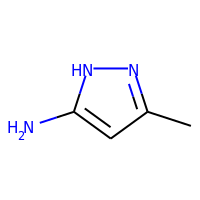
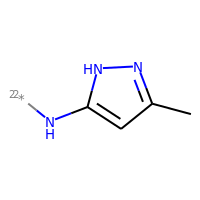
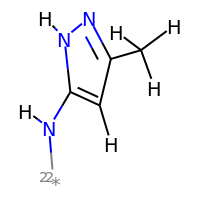
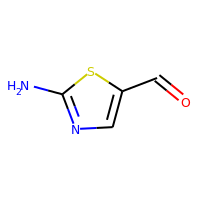
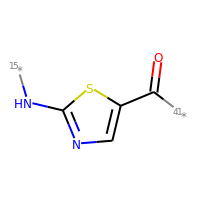
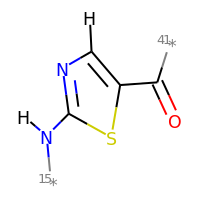
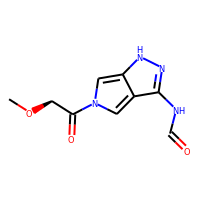
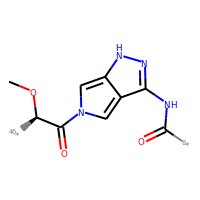
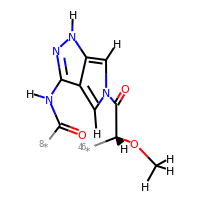

In [9]:
fragment_library_pre_filtered['AP'].head()

In [10]:
pd.concat([filters.analysis.count_fragments(fragment_library,
                                            'original'),
           filters.analysis.count_fragments(fragment_library_pre_filtered,
                                            'pre_filtered')],
          axis=1)

,original,pre_filtered
subpocket,,
AP,2561,1001
FP,1866,864
SE,1560,607
GA,1024,306
B1,98,42
B2,92,42


For further use we save fragment_library as fragment_library_original and fragment_library_pre_filtered as fragment_library.

In [11]:
fragment_library_original = fragment_library.copy()
fragment_library = fragment_library_pre_filtered.copy()

## 3. Filter for buyable building blocks
The [Enamine REAL Space](https://enamine.net/compound-collections/real-compounds/real-space-navigator) contains over 19 billion building blocks that can be synthesized on demand. [DataWarrior](https://openmolecules.org/datawarrior/index.html) is an open source software which can be used searching building blocks in this huge chemical space.

In [12]:
d = filters.building_blocks.check_building_blocks(
    fragment_library,
    str(str(PATH_DATA)+'/filters/DataWarrior/Enamine_Building_Blocks.sdf'))

In [13]:
bb_frags = d['enamine_bb_fragments']
not_bb_frags = d['not_enamine_bb_fragments']
fragment_library_enamine = d['fragment_library']

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",0
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0

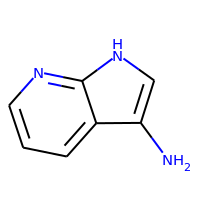
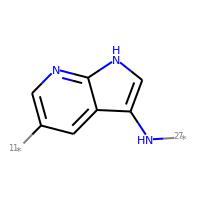
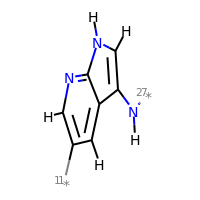
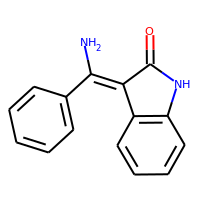
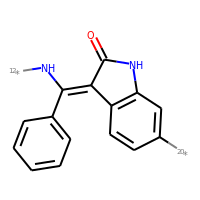
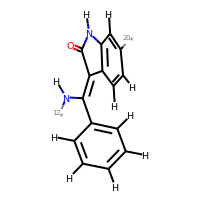
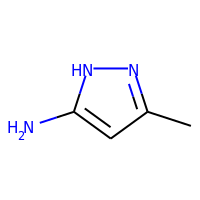
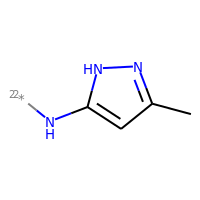
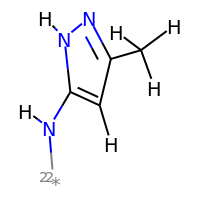
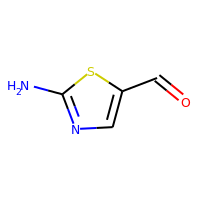
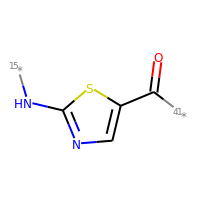
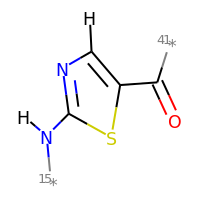
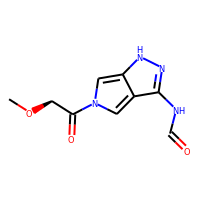
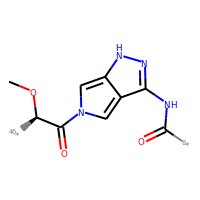
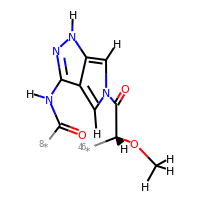

In [14]:
fragment_library_enamine['AP'].head()

In [15]:
pd.concat([filters.analysis.count_fragments(
    fragment_library_enamine,
    "pre_filtered"),
          filters.analysis.count_accepted_rejected(
              fragment_library_enamine,
              'bool_bb',
              'enamine')],
          axis=1)

,pre_filtered,accepted_enamine,rejected_enamine
subpocket,,,
AP,1001,178,823
FP,864,224,640
SE,607,163,444
GA,306,151,155
B1,42,16,26
B2,42,19,23


In [16]:
# save superstructure df as fragment_library_synthesizability to use
fragment_library_synthesizability = fragment_library_enamine.copy()

## 4. Filter for SYnthetic Bayesian Accessibility (SYBA)

The SYnthtetic Bayesian Accessibility Score [SYBA](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2) is a Bayesian probabilistic modeling [method](https://github.com/lich-uct/syba) calculating a fragment-based score by using the frequency of fragments in easy- and hard-to-synthesizable molecules. Where a more negative score indicates more hard to synthesize molecules and a more positive score more easy to synthesize molecules.

In [17]:
d_sybas = filters.syba.calc_syba(
    fragment_library_synthesizability,
    cutoff=0)

In [18]:
accepted_frags_syba = d_sybas['df_accepted']
rejected_frags_syba = d_sybas['df_rejected']
fragment_library_synthesizability = d_sybas['fragment_library']
sybascore = d_sybas['sybas']

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",0
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0

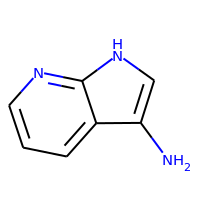
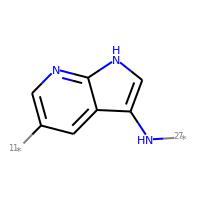
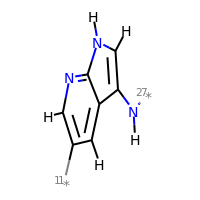
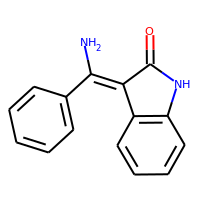
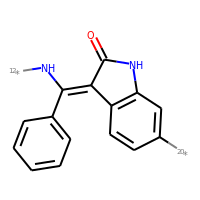
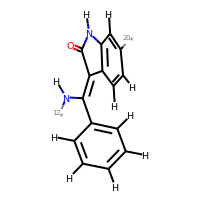
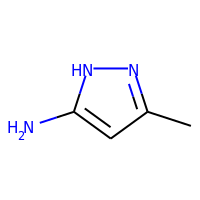
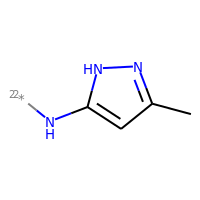
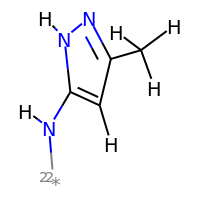
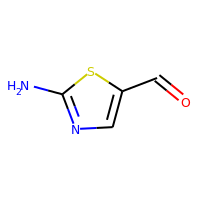
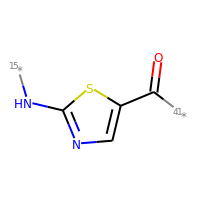
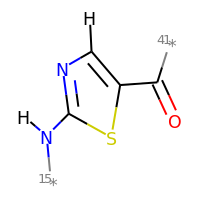
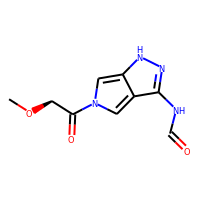
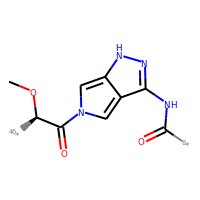
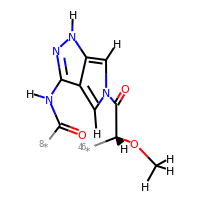

In [19]:
accepted_frags_syba['AP'].head()

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb
0,AP,O=C1NCCCc2cc[nH]c21,,,,ACK,Ack,TK,1u4d,DBQ,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 na,[19*]=C1CCNC(=O)c2[nH]ccc21,4,[FP],[AP=FP],0
1,AP,C[C@@H]1SCc2ncncc21,,,,AKT1,Akt,AGC,3ow4,SMY,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 1...,[17*]c1ncnc2c1[C@H](C)SC2,1,[FP],[AP=FP],0
2,AP,C[C@@H]1C[C@@H](O)c2ncncc21,,,,AKT1,Akt,AGC,4ekl,0RF,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 1...,[14*]c1ncnc2c1[C@H](C)C[C@H]2O,1,[FP],[AP=FP],0
3,AP,C[C@@H]1CC(=O)Nc2ncncc21,,,,AKT1,Akt,AGC,6ccy,EX4,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 1...,[36*]c1ncnc2c1[C@H](C)CC(=O)N2,1,[FP],[AP=FP],0
4,AP,O=CNc1n[nH]c2c1CNC2,,,,ALK,ALK,TK,2xba,571,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 5 5 6 6 14 14 14 14 14 14 14 14...,[8*]C(=O)Nc1n[nH]c2c1CN([46*])C2,2,"[GA, SE]","[AP=GA, AP=SE]",0

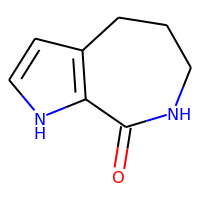
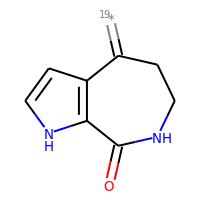
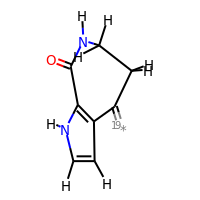
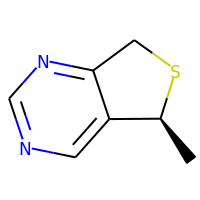
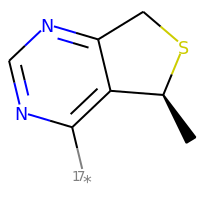
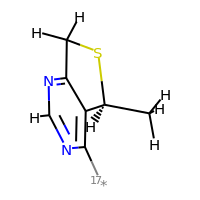
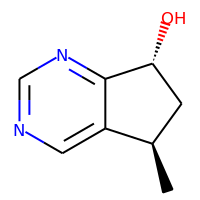
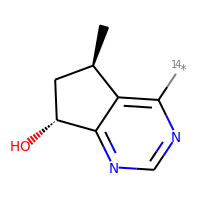
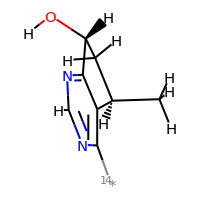
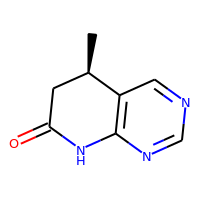
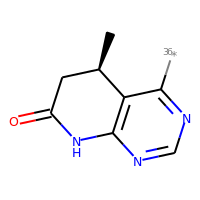
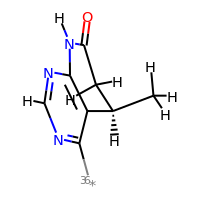
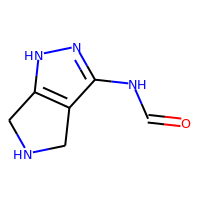
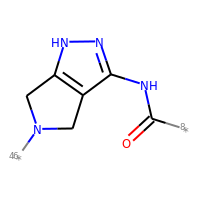
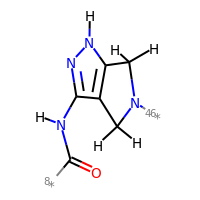

In [20]:
rejected_frags_syba['AP'].head()

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb,bool_syba
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",0,1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0,1
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1,1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1,1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0,1

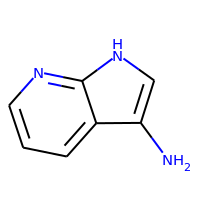
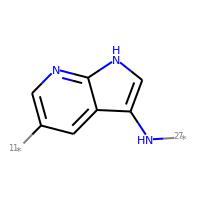
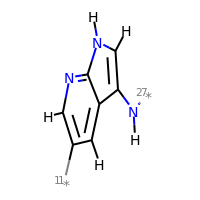
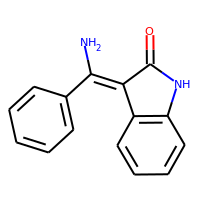
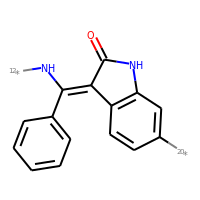
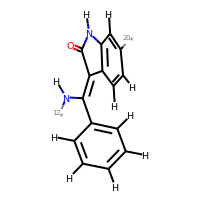
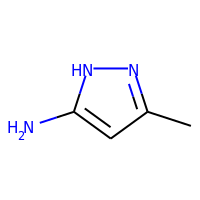
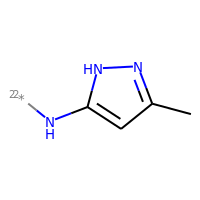
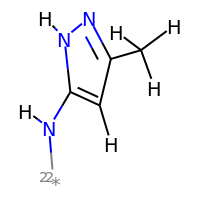
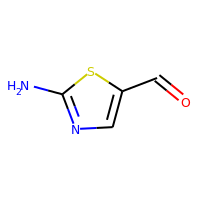
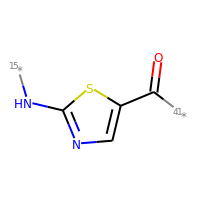
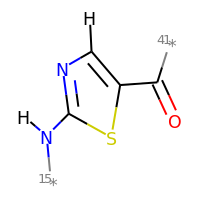
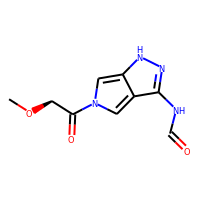
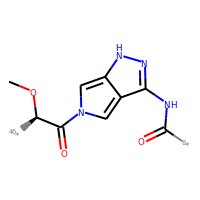
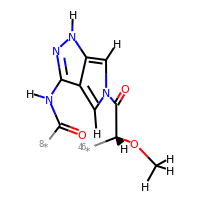

In [21]:
fragment_library_synthesizability['AP'].head()

In [22]:
pd.concat([filters.analysis.count_fragments(
    fragment_library_synthesizability,
    'pre_filtered'),
          filters.analysis.count_accepted_rejected(
              fragment_library_synthesizability,
              'bool_syba', 'syba')],
          axis=1)

,pre_filtered,accepted_syba,rejected_syba
subpocket,,,
AP,1001,899,102
FP,864,689,175
SE,607,551,56
GA,306,280,26
B1,42,32,10
B2,42,39,3


## 5. Analyse accepted/rejected fragments

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,...,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_bb,bool_syba,bool,bool_1
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,...,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",0,1,0,1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,...,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",0,1,0,1
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,...,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1,1,1,1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,...,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1,1,1,1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,...,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0,1,0,1

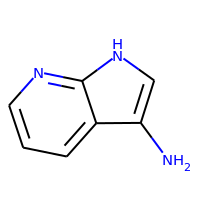
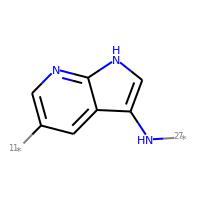
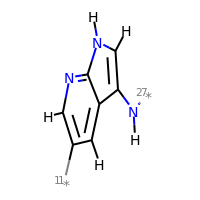
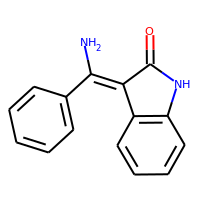
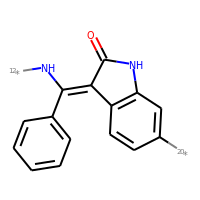
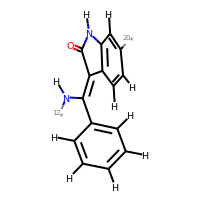
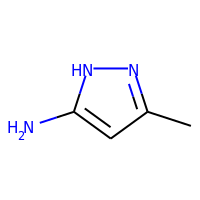
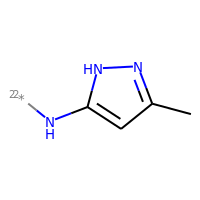
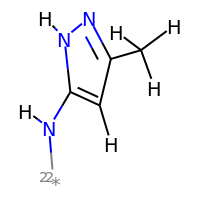
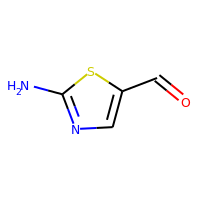
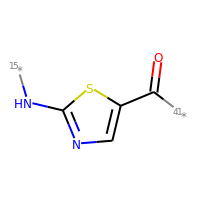
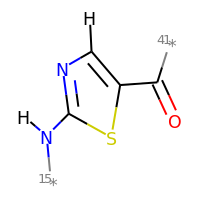
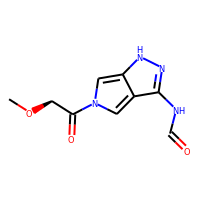
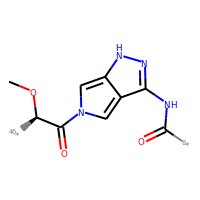
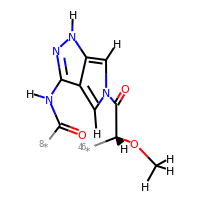

In [23]:
fragment_library_synthesizability = filters.analysis.number_of_accepted(
    fragment_library_synthesizability, columns=['bool_syba', 'bool_bb'],
    min_accepted=2)
fragment_library_synthesizability = filters.analysis.number_of_accepted(
    fragment_library_synthesizability,
    columns=['bool_syba', 'bool_bb'],
    min_accepted=1,
    name="bool_1")
fragment_library_synthesizability['AP'].head()

In [24]:
pd.concat([filters.analysis.count_fragments(
    fragment_library_synthesizability,
    'pre_filtered'),
          filters.analysis.count_accepted_rejected(
              fragment_library_synthesizability,
              'bool', 'both'),
          filters.analysis.count_accepted_rejected(
              fragment_library_synthesizability,
              'bool_syba', 'syba'),
          filters.analysis.count_accepted_rejected(
              fragment_library_synthesizability,
              'bool_bb', 'enamine_superstr'),
          filters.analysis.count_accepted_rejected(
              fragment_library_synthesizability,
              'bool_1', 'one')],
          axis=1)

,pre_filtered,accepted_both,rejected_both,accepted_syba,rejected_syba,accepted_enamine_superstr,rejected_enamine_superstr,accepted_one,rejected_one
subpocket,,,,,,,,,
AP,1001,175,826,899,102,178,823,902,99
FP,864,186,678,689,175,224,640,727,137
SE,607,145,462,551,56,163,444,569,38
GA,306,141,165,280,26,151,155,290,16
B1,42,15,27,32,10,16,26,33,9
B2,42,18,24,39,3,19,23,40,2


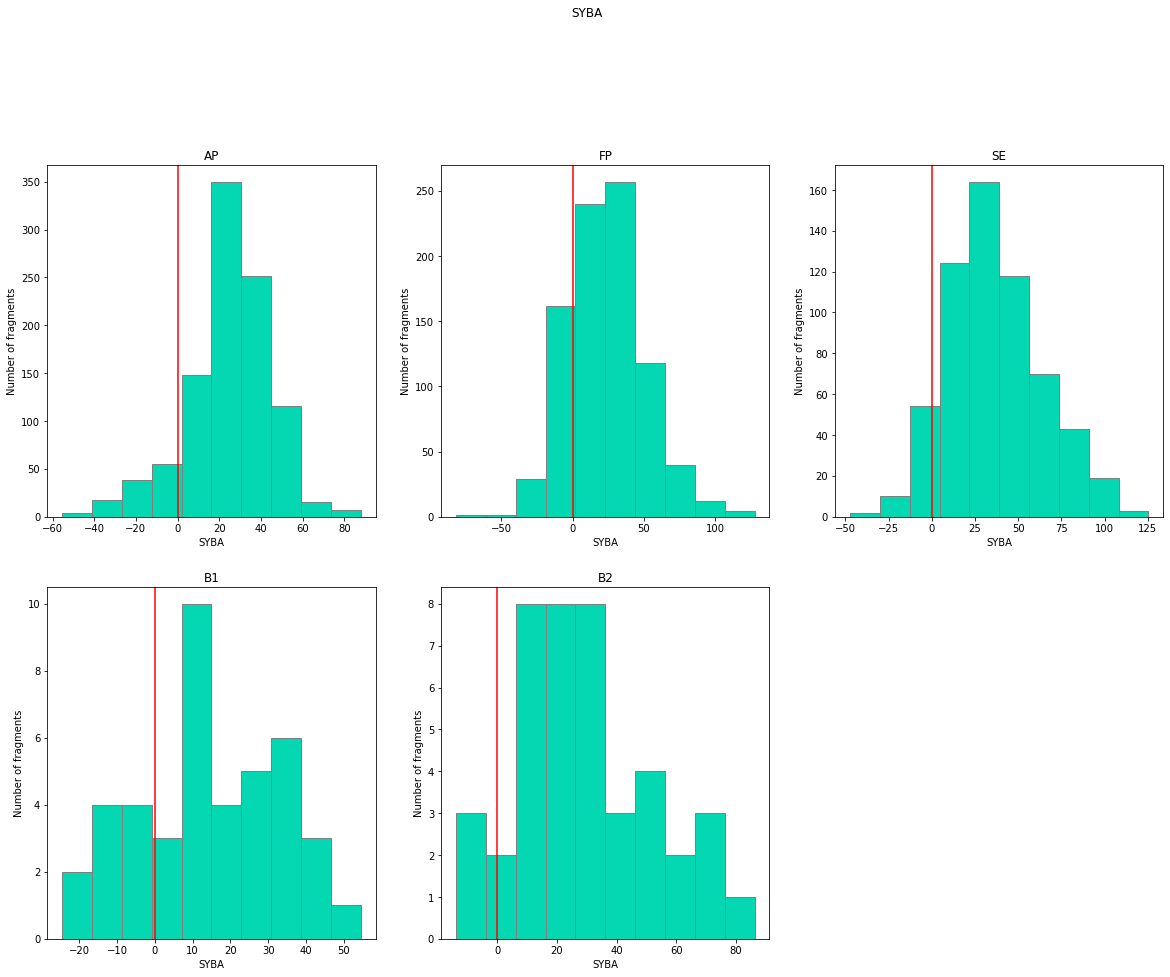

In [25]:
filters.plots.make_hists(
    sybascore,
    fragment_library,
    'SYBA',
    plot_stats=False,
    cutoff=0)

Todo: more analysis